<a href="https://colab.research.google.com/github/Deepak-Mewada/NeuralDecoder/blob/main/BrainDecoder/Basics/plot_tuh_eeg_corpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Process a big data EEG resource (TUH EEG Corpus)

In this example, we showcase usage of the Temple University Hospital EEG Corpus
(https://www.isip.piconepress.com/projects/tuh_eeg/html/downloads.shtml#c_tueg)
including simple preprocessing steps as well as cutting of compute windows.
   :depth: 2


In [2]:
!pip install braindecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.2/165.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.0 MB/s eta 0:00:00


In [3]:
import tempfile

import numpy as np
import matplotlib.pyplot as plt
import mne

from braindecode.datasets import TUH
from braindecode.preprocessing import (
    preprocess, Preprocessor, create_fixed_length_windows)
from numpy import multiply

mne.set_log_level('ERROR')  # avoid messages every time a window is extracted

## Creating the dataset using TUHMock

Since the data is not available at the time of the creation of this example,
we are required to mock some of the dataset functionality. Therefore, if you
want to try this code with the actual data, please disconsider this section.



In [4]:
from braindecode.datasets.tuh import _TUHMock as TUH  # noqa F811

Firstly, we start by creating a TUH mock dataset using braindecode's _TUHMock class.
The complete code can be found at :func:`braindecode.datasets.TUH`, but we will give
a small description of how it works.
This class is able to read the recordings from TUH_PATH and generate a description
by parsing information from file paths, such as patient id and recording data.
THis description can later be accessed by the object's .description method.
After that, the files are sorted chronologically by year, month, day,
patient id, recording session and segment, and then use the description corresponding
to the specified by recording ids.
FInally, additional information regarding age and gender of the subjects are parsed
directly to the description.



In [5]:
TUH_PATH = 'please insert actual path to data here'
# specify the number of jobs for loading and windowing
N_JOBS = 2
tuh = TUH(
    path=TUH_PATH,
    recording_ids=None,
    target_name=None,
    preload=False,
    add_physician_reports=False,
    n_jobs=1 if TUH.__name__ == '_TUHMock' else N_JOBS
)

We can visualize our data's statistics using the class' "description" method



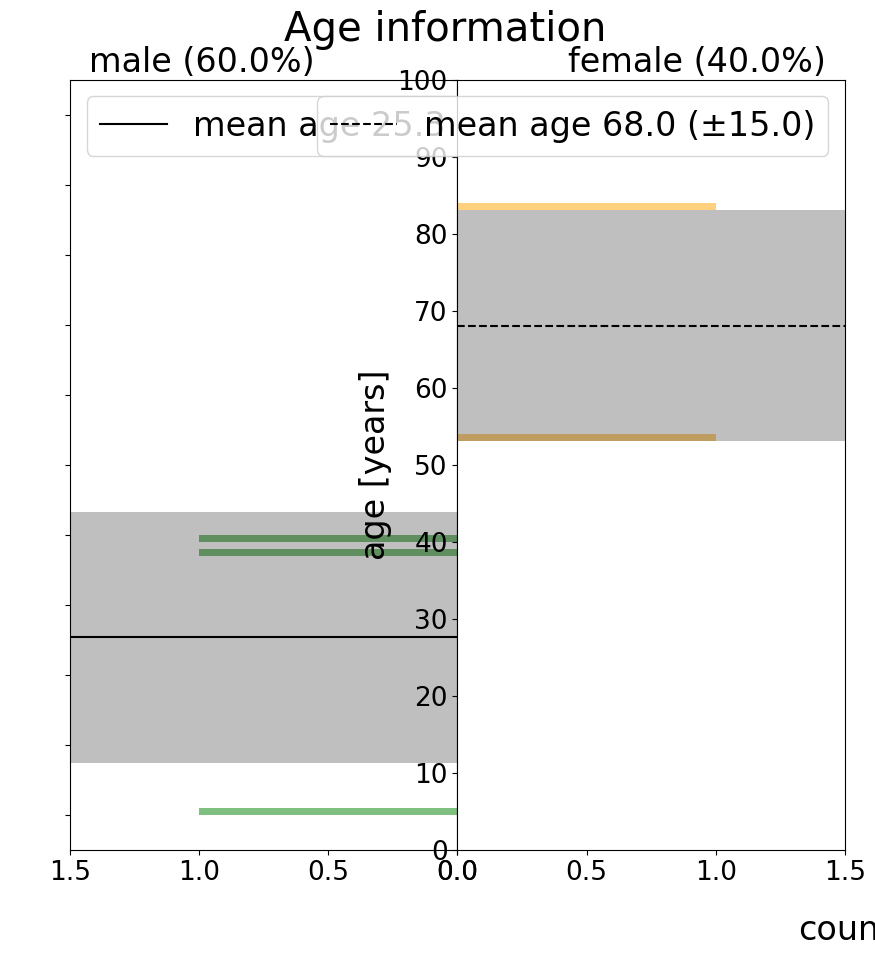

In [12]:
def plt_histogram(df_of_ages_genders, alpha=0.5, fs=24, ylim=1.5, show_title=True):
    # Dafarame containing info about gender and age of subjects
    df = df_of_ages_genders
    male_df = df[df["gender"] == 'M']
    female_df = df[df["gender"] == 'F']

    plt.figure(figsize=(10, 10))
    if show_title:
        plt.suptitle("Age information", y=0.95, fontsize=fs + 5)

    # First plot: Male individuals
    plt.subplot(121)
    plt.hist(male_df["age"], bins=np.linspace(0, 100, 101),
             alpha=alpha, color="green", orientation="horizontal")
    plt.axhline(np.mean(male_df["age"]), color="black",
                label=f"mean age {np.mean(male_df['age']):.1f} "
                      f"(±{np.std(male_df['age']):.1f})")
    plt.barh(np.mean(male_df["age"]), height=2 * np.std(male_df["age"]),
             width=ylim, color="black", alpha=0.25)

    # Legend
    plt.xlim(0, ylim)
    plt.legend(fontsize=fs, loc="upper left")
    plt.title(f"male ({100 * len(male_df) / len(df):.1f}%)",
              fontsize=fs, loc="left", y=1, x=0.05)
    plt.yticks(color='w')
    plt.gca().invert_xaxis()
    plt.yticks(np.linspace(0, 100, 11), fontsize=fs - 5)
    plt.tick_params(labelsize=fs - 5)

    # First plot: Female individuals
    plt.subplot(122)
    plt.hist(female_df["age"], bins=np.linspace(0, 100, 101),
             alpha=alpha, color="orange", orientation="horizontal")
    plt.axhline(np.mean(female_df["age"]), color="black", linestyle="--",
                label=f"mean age {np.mean(female_df['age']):.1f} ("
                      f"±{np.std(female_df['age']):.1f})")
    plt.barh(np.mean(female_df["age"]), height=2 * np.std(female_df["age"]),
             width=ylim, color="black", alpha=0.25)

    # Label
    plt.legend(fontsize=fs, loc="upper right")
    plt.xlim(0, ylim)
    plt.title(f"female ({100 * len(female_df) / len(df):.1f}%)",
              fontsize=fs, loc="right", y=1, x=0.95)
    plt.ylim(0, 100)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.ylabel("age [years]", fontsize=fs)
    plt.xlabel("count", fontsize=fs, x=1, labelpad=20)
    plt.yticks(np.linspace(0, 100, 11), fontsize=fs - 5)
    plt.tick_params(labelsize=fs - 5)

    plt.show()


df = tuh.description
plt_histogram(df)

## Preprocessing

### Selecting recordings

First, we will do some selection of available recordings based on the duration.
We will select those recordings that have at least five minutes duration.




In [7]:
def select_by_duration(ds, tmin=0, tmax=None):
    if tmax is None:
        tmax = np.inf
    # determine length of the recordings and select based on tmin and tmax
    split_ids = []
    for d_i, d in enumerate(ds.datasets):
        duration = d.raw.n_times / d.raw.info['sfreq']
        # select the ones in the required duration range
        if tmin <= duration <= tmax:
            split_ids.append(d_i)
    splits = ds.split(split_ids)
    split = splits['0']
    return split


tmin = 5 * 60
tmax = None
tuh = select_by_duration(tuh, tmin, tmax)

Next, we will discard all recordings that have an incomplete channel
configuration on the channels that we are interested. The subdivisions of the
recordings into 'le' and 'ar' labels represents the channels for
the re-referencing of the signals.



In [8]:
short_ch_names = sorted([
    'A1', 'A2',
    'FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
    'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ'])

# TUH data is subdivided into 'le' and 'ar' recordings references
ar_ch_names = sorted([
    'EEG A1-REF', 'EEG A2-REF',
    'EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF',
    'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF',
    'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF',
    'EEG T6-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF'])
le_ch_names = sorted([
    'EEG A1-LE', 'EEG A2-LE',
    'EEG FP1-LE', 'EEG FP2-LE', 'EEG F3-LE', 'EEG F4-LE', 'EEG C3-LE',
    'EEG C4-LE', 'EEG P3-LE', 'EEG P4-LE', 'EEG O1-LE', 'EEG O2-LE',
    'EEG F7-LE', 'EEG F8-LE', 'EEG T3-LE', 'EEG T4-LE', 'EEG T5-LE',
    'EEG T6-LE', 'EEG FZ-LE', 'EEG CZ-LE', 'EEG PZ-LE'])
assert len(short_ch_names) == len(ar_ch_names) == len(le_ch_names)
ar_ch_mapping = {ch_name: short_ch_name for ch_name, short_ch_name in zip(
    ar_ch_names, short_ch_names)}
le_ch_mapping = {ch_name: short_ch_name for ch_name, short_ch_name in zip(
    le_ch_names, short_ch_names)}
ch_mapping = {'ar': ar_ch_mapping, 'le': le_ch_mapping}


def select_by_channels(ds, ch_mapping):
    split_ids = []
    for i, d in enumerate(ds.datasets):
        ref = 'ar' if d.raw.ch_names[0].endswith('-REF') else 'le'
        # these are the channels we are looking for
        seta = set(ch_mapping[ref].keys())
        # these are the channels of the recoding
        setb = set(d.raw.ch_names)
        # if recording contains all channels we are looking for, include it
        if seta.issubset(setb):
            split_ids.append(i)
    return ds.split(split_ids)['0']


tuh = select_by_channels(tuh, ch_mapping)

### Combining preprocessing steps

Next, we use braindecode's preprocess to combine and execute several preprocessing
steps that are executed through 'mne':

- Crop the recordings to a region of interest
- Re-reference all recordings to 'ar' (requires load)
- Rename channels to short channel names
- Pick channels of interest
- Scale signals to micro volts (requires load)
- Clip outlier values to +/- 800 micro volts (requires load)
- Resample recordings to a common frequency (requires load)



In [9]:
def custom_rename_channels(raw, mapping):
    # rename channels which are dependent on referencing:
    # le: EEG 01-LE, ar: EEG 01-REF
    # mne fails if the mapping contains channels as keys that are not present
    # in the raw
    reference = raw.ch_names[0].split('-')[-1].lower()
    assert reference in ['le', 'ref'], 'unexpected referencing'
    reference = 'le' if reference == 'le' else 'ar'
    raw.rename_channels(mapping[reference])


def custom_crop(raw, tmin=0.0, tmax=None, include_tmax=True):
    # crop recordings to tmin – tmax. can be incomplete if recording
    # has lower duration than tmax
    # by default mne fails if tmax is bigger than duration
    tmax = min((raw.n_times - 1) / raw.info['sfreq'], tmax)
    raw.crop(tmin=tmin, tmax=tmax, include_tmax=include_tmax)


tmin = 1 * 60
tmax = 6 * 60
sfreq = 100
factor = 1e6

preprocessors = [
    Preprocessor(custom_crop, tmin=tmin, tmax=tmax, include_tmax=False,
                 apply_on_array=False),
    Preprocessor('set_eeg_reference', ref_channels='average', ch_type='eeg'),
    Preprocessor(custom_rename_channels, mapping=ch_mapping,
                 apply_on_array=False),
    Preprocessor('pick_channels', ch_names=short_ch_names, ordered=True),
    Preprocessor(lambda data: multiply(data, factor), apply_on_array=True),  # Convert from V to uV
    Preprocessor(np.clip, a_min=-800, a_max=800, apply_on_array=True),
    Preprocessor('resample', sfreq=sfreq),
]

/usr/local/lib/python3.10/dist-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


Next, we can apply the defined preprocessors on the selected recordings in parallel.
We additionally use the serialization functionality of
:func:`braindecode.preprocessing.preprocess` to limit memory usage during
preprocessing, as each file must be loaded into memory for some of the
preprocessing steps to work.
This also makes it possible to use the lazy
loading capabilities of :class:`braindecode.datasets.BaseConcatDataset`, as
the preprocessed data is automatically reloaded with ``preload=False``.

<div class="alert alert-info"><h4>Note</h4><p>Here we use ``n_jobs=2`` as the machines the documentation is build on
   only have two cores. This number should be modified based on the machine
   that is available for preprocessing.</p></div>



In [10]:
OUT_PATH = tempfile.mkdtemp()  # please insert actual output directory here
tuh_preproc = preprocess(
    concat_ds=tuh,
    preprocessors=preprocessors,
    n_jobs=N_JOBS,
    save_dir=OUT_PATH
)

### Cut Compute Windows
We can finally generate compute windows. The resulting dataset is now ready
to be used for model training.



In [11]:
window_size_samples = 1000
window_stride_samples = 1000
# Generate compute windows here and store them to disk
tuh_windows = create_fixed_length_windows(
    tuh_preproc,
    window_size_samples=window_size_samples,
    window_stride_samples=window_stride_samples,
    drop_last_window=False,
    n_jobs=N_JOBS,
)